In [3]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(stringr))
library(plyr)
library(purrr)
library(rstatix)
library(ggpubr)

In [23]:

is_dark_color <- function(hex) {
  rgb <- col2rgb(hex)
  
  luminance <- 0.299 * rgb[1,] + 0.587 * rgb[2,] + 0.114 * rgb[3,]
  if(luminance < 128){
  return('white')
  } else {return('black')}
}

In [19]:
color_annotation<-read.csv('../Color_hex_codes/Cell_Type_Color_Annotation_and_Order.csv')
color_annotation$label<-gsub(' cell','',color_annotation$label)
color_vector <- setNames(color_annotation$color, color_annotation$label)

In [12]:
df<-read.csv("02_Flow_scRNA_Frequency_Comparison/flow_scRNA_Freq.csv") %>% filter(AIFI_L3_matched=='non_B')

In [24]:
df$AIFI_L3_matched<-gsub(' cell','',df$AIFI_L3_matched)


In [35]:
add_spearman_correlation <- function(data, mapping, ...) {
  x <- eval_tidy(mapping$x, data)
  y <- eval_tidy(mapping$y, data)
  cor_test <- cor.test(x, y, method = "spearman")
  label <- paste0("rho = ", round(cor_test$estimate, 2), "\np = ", format.pval(cor_test$p.value, digits = 2))
  ggplot2::annotate("text", x = -Inf, y = Inf, label = label, hjust = -0.1, vjust = 1.1, size = 2.5, ...)
}

In [70]:
df <- df %>%
  mutate(`Age Group` = case_when(
    startsWith(subject.subjectGuid, "BR1") ~ 'Young',
    TRUE ~ 'Older'
  ))

`geom_smooth()` using formula = 'y ~ x'


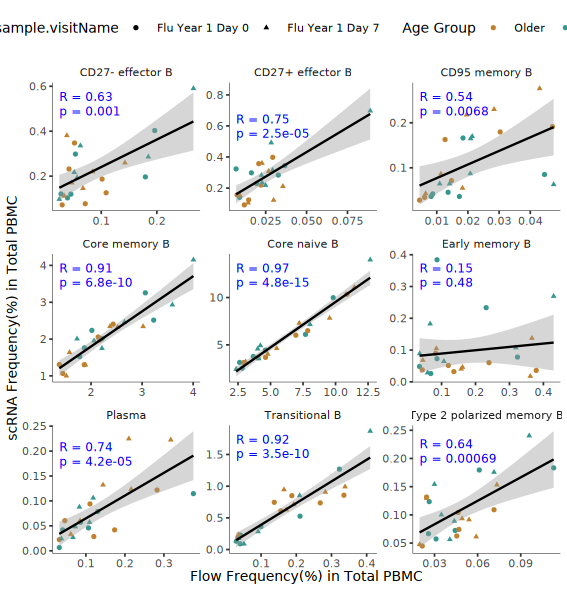

In [76]:
options(repr.plot.width = 120/25.4, repr.plot.height = 125/25.4)

p <- ggplot(data = df, aes(x = frequency_Flow, y = frequency_scRNA)) + 
  geom_point(size=1.2, stroke=0, aes(shape= sample.visitName,color=`Age Group`	)) +
  theme_classic(base_size=8) +
  geom_smooth(method=lm , color="black", linewidth=0.5,  se=TRUE) +    scale_color_manual(values = c("Older" = '#bf812d', "Young" = '#35978f'))+

  theme(
    axis.line = element_line(colour = "black", linewidth = 0.1),
    legend.position = "top",
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    panel.border = element_blank(),
    panel.background = element_blank(),
    strip.background = element_rect(linewidth = 0),
    axis.title.x = element_text(margin = margin(t = 1))
  ) +
  facet_wrap(~AIFI_L3_matched, ncol=3, scales='free') +
  stat_cor(aes(label = ..r.label..), method = "pearson", size = 2.5, label.x.npc = 'left', color='blue',label.y.npc = 'top') +
  stat_cor(aes(label = ..p.label..), method = "pearson", size = 2.5, label.x.npc = 'left', color='blue',label.y.npc = 'top', vjust = 2.5)+
ylab("scRNA Frequency(%) in Total PBMC")+
xlab("Flow Frequency(%) in Total PBMC")

print(p)

`geom_smooth()` using formula = 'y ~ x'


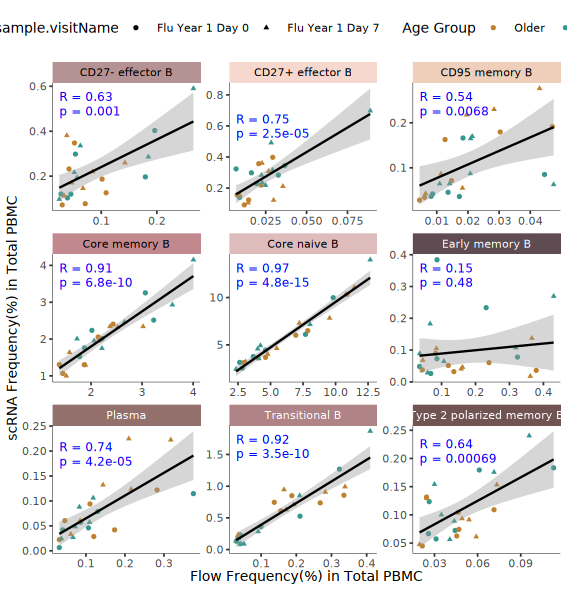

In [77]:
plot <- ggplot_gtable(ggplot_build(p))

strips <- which(grepl('strip-', plot$layout$name))
strip_labels <- sapply(strips, function(i) {
  plot$grobs[[i]]$grobs[[1]]$children[[2]]$children[[1]]$label
})
strip_labels<-gsub(' cell','',strip_labels)

pal <- color_vector[strip_labels]
text_color <- sapply(color_vector[strip_labels], is_dark_color)

strip_names <- plot$layout$name[strips]


for (i in seq_along(strips)) {
  strip_name <- strip_names[i]

  
  k <- which(grepl('rect', plot$grobs[[strips[i]]]$grobs[[1]]$childrenOrder))
  l <- which(grepl('titleGrob', plot$grobs[[strips[i]]]$grobs[[1]]$childrenOrder))
  
  adjusted_color <- adjustcolor(pal[i], alpha.f = 0.8)
  
  plot$grobs[[strips[i]]]$grobs[[1]]$children[[k]]$gp$fill <- adjusted_color
  plot$grobs[[strips[i]]]$grobs[[1]]$children[[l]]$children[[1]]$gp$col <- text_color[i]
}

plot(plot)
ggsave('FigureB.pdf',plot,width = 120/25.4,height = 125/25.4)